## Data Exploration
Aqui vou explorar as características da série temporal
- Plotar gráficos de box-plot, histogramas e de linhas por anos
- Analisar 
  - distribuition
  - seasonal
  - trend
  - cyclic
- Teste de estacionariedade

## Import

In [23]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
import statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os

## Prepare Principal Directory

In [24]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [25]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Cell Format

In [26]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.float_format', '{:.5}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')



# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Load Data

In [28]:
%%time

df_vale3 = pd.read_csv('data/raw/vale3_2010-2020.csv',
                              encoding='utf8',
                              delimiter=',',
                              verbose=True)

Tokenization took: 0.53 ms
Type conversion took: 1.69 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 5.97 ms, sys: 735 µs, total: 6.71 ms
Wall time: 6.2 ms


In [29]:
df_vale3.head(15)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 19, 2020",55.17,56.33,56.6,54.71,37.86M,-1.78%
1,"Jun 18, 2020",56.17,56.3,56.54,55.61,25.69M,-0.05%
2,"Jun 17, 2020",56.2,55.49,56.44,55.15,27.57M,1.46%
3,"Jun 16, 2020",55.39,55.49,55.5,54.22,29.17M,2.80%
4,"Jun 15, 2020",53.88,52.5,54.43,52.13,27.32M,0.90%
5,"Jun 12, 2020",53.4,53.71,54.05,51.98,31.18M,-1.48%
6,"Jun 10, 2020",54.2,54.91,55.2,53.76,24.19M,-1.44%
7,"Jun 09, 2020",54.99,54.16,54.99,54.12,19.61M,0.38%
8,"Jun 08, 2020",54.78,54.98,55.65,53.98,27.19M,0.31%
9,"Jun 05, 2020",54.61,56.39,56.7,54.34,39.64M,-1.89%


## EDA: exploratory data analysis

1. Colunas:
- Date (eixo x): data dos dados
- Price (eixo y): é o preço de fechamento. O que será previsto
- Open: preço de abertura
- High: preço máximo atingido
- Low: preço mínimo atingido
- Vol.: volume de ações negociadas
- Change %: porcentagem de alteração em relação ao dia anterior

<br/>

2. Contexto:
- Mercado de ações
- VALE3

#### Data Format

In [30]:
print("Dataframe:\n{} rows\n{} columns".format(df_vale3.shape[0],
                                               df_vale3.shape[1]))

Dataframe:
2495 rows
7 columns


#### Columns

In [31]:
list_columns = (df_vale3.columns).tolist()

print("-"*25, "List Columns", "-"*25, end='\n')
display(list_columns)

------------------------- List Columns -------------------------


['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

In [32]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2495 non-null   object 
 1   Price     2495 non-null   float64
 2   Open      2495 non-null   float64
 3   High      2495 non-null   float64
 4   Low       2495 non-null   float64
 5   Vol.      2495 non-null   object 
 6   Change %  2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB


In [33]:
df_vale3.nunique()

Date        2495
Price       1845
Open        1816
High        1852
Low         1845
Vol.        1339
Change %     927
dtype: int64

In [34]:
def show_measures_location(df: 'dataframe', type_descr: 'list') -> None:
    """
    Function get measures localization + total col + % type columns 
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [35]:
show_measures_location(df=df_vale3,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 7
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


,Date,Price,Open,High,Low,Vol.,Change %
count,2495,2495.0,2495.0,2495.0,2495.0,2495,2495
unique,2495,nan,nan,nan,nan,1339,927
top,"Jun 28, 2017",nan,nan,nan,nan,3.99M,0.00%
freq,1,nan,nan,nan,nan,9,20
mean,NaN,35.802,35.828,36.317,35.316,NaN,NaN
std,NaN,12.277,12.28,12.344,12.184,NaN,NaN
min,NaN,8.6,8.75,9.06,8.6,NaN,NaN
25%,NaN,26.88,26.93,27.34,26.605,NaN,NaN
50%,NaN,36.88,36.87,37.42,36.3,NaN,NaN
75%,NaN,46.355,46.33,46.83,45.73,NaN,NaN


#### Missing values

In [36]:
df_vale3.isnull().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

#### Duplicate Records

In [37]:
df_vale3.duplicated().any()

False

---

# Preprocessing

#### Columns to lowercase

In [38]:
df_vale3.columns =  map(str.lower, df_vale3.columns)
print(df_vale3.columns)

Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')


#### Drop Columns

In [39]:
df_vale3.drop(['change %'], axis=1, inplace=True)

#### List Columns

In [40]:
list_columns = []
list_columns = df_vale3.columns

list_columns

Index(['date', 'price', 'open', 'high', 'low', 'vol.'], dtype='object')

### Format Columns

#### Column: vol.
- renomear para `volume`
- Remover o `M` e o `K`
- Substituir as células `-` pela moda

In [41]:
df_vale3.columns = ['date', 'price', 'open', 'high', 'low', 'volume']
list_columns = df_vale3.columns
df_vale3.head()

,date,price,open,high,low,volume
0,"Jun 19, 2020",55.17,56.33,56.6,54.71,37.86M
1,"Jun 18, 2020",56.17,56.3,56.54,55.61,25.69M
2,"Jun 17, 2020",56.2,55.49,56.44,55.15,27.57M
3,"Jun 16, 2020",55.39,55.49,55.5,54.22,29.17M
4,"Jun 15, 2020",53.88,52.5,54.43,52.13,27.32M


In [42]:
df_vale3['volume'] = df_vale3['volume'].replace({'M':'000'}, regex=True)
df_vale3['volume'] = df_vale3['volume'].replace({'K':'00'}, regex=True)
df_vale3['volume'][:15]

0     37.86000
1     25.69000
2     27.57000
3     29.17000
4     27.32000
5     31.18000
6     24.19000
7     19.61000
8     27.19000
9     39.64000
10    37.38000
11           -
12    25.42000
13    27.01000
14    92.24000
Name: volume, dtype: object

In [43]:
mode_df_vale3_volume = df_vale3['volume'].mode()[0]
mode_df_vale3_volume

'3.99000'

In [44]:
df_vale3.query('volume == "-"')

,date,price,open,high,low,volume
11,"Jun 03, 2020",53.66,53.42,54.33,53.39,-


In [45]:
df_vale3['volume'][11] = mode_df_vale3_volume

In [46]:
df_vale3.head(12)

,date,price,open,high,low,volume
0,"Jun 19, 2020",55.17,56.33,56.6,54.71,37.86000
1,"Jun 18, 2020",56.17,56.3,56.54,55.61,25.69000
2,"Jun 17, 2020",56.2,55.49,56.44,55.15,27.57000
3,"Jun 16, 2020",55.39,55.49,55.5,54.22,29.17000
4,"Jun 15, 2020",53.88,52.5,54.43,52.13,27.32000
5,"Jun 12, 2020",53.4,53.71,54.05,51.98,31.18000
6,"Jun 10, 2020",54.2,54.91,55.2,53.76,24.19000
7,"Jun 09, 2020",54.99,54.16,54.99,54.12,19.61000
8,"Jun 08, 2020",54.78,54.98,55.65,53.98,27.19000
9,"Jun 05, 2020",54.61,56.39,56.7,54.34,39.64000


In [47]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2495 non-null   object 
 1   price   2495 non-null   float64
 2   open    2495 non-null   float64
 3   high    2495 non-null   float64
 4   low     2495 non-null   float64
 5   volume  2495 non-null   object 
dtypes: float64(4), object(2)
memory usage: 117.1+ KB


In [48]:
df_vale3['volume'] = df_vale3['volume'].astype(dtype='float64', errors='raise')

In [49]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2495 non-null   object 
 1   price   2495 non-null   float64
 2   open    2495 non-null   float64
 3   high    2495 non-null   float64
 4   low     2495 non-null   float64
 5   volume  2495 non-null   float64
dtypes: float64(5), object(1)
memory usage: 117.1+ KB


In [50]:
df_vale3.head()

,date,price,open,high,low,volume
0,"Jun 19, 2020",55.17,56.33,56.6,54.71,37.86
1,"Jun 18, 2020",56.17,56.3,56.54,55.61,25.69
2,"Jun 17, 2020",56.2,55.49,56.44,55.15,27.57
3,"Jun 16, 2020",55.39,55.49,55.5,54.22,29.17
4,"Jun 15, 2020",53.88,52.5,54.43,52.13,27.32


#### Format Date
- Transforma o formato da data (Jun 19, 2020) em (2020-06-19)
- Transforma a o tipo da coluna `date` para `datetime64`

In [51]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'])
print(df_vale3['date'].head())

0   2020-06-19
1   2020-06-18
2   2020-06-17
3   2020-06-16
4   2020-06-15
Name: date, dtype: datetime64[ns]


In [52]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'],
                                  format='%Y/%m/%d',
                                  errors='raise')

In [53]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2495 non-null   datetime64[ns]
 1   price   2495 non-null   float64       
 2   open    2495 non-null   float64       
 3   high    2495 non-null   float64       
 4   low     2495 non-null   float64       
 5   volume  2495 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 117.1 KB


## Use date how index

In [54]:
df_vale3_date_index = df_vale3
df_vale3_date_index.index.names = ['date']
df_vale3_date_index.index = df_vale3['date']
df_vale3_date_index.index = pd.to_datetime(df_vale3.index)

print(df_vale3_date_index.index.freq)
print(df_vale3_date_index.index)

None
DatetimeIndex(['2020-06-19', '2020-06-18', '2020-06-17', '2020-06-16',
               '2020-06-15', '2020-06-12', '2020-06-10', '2020-06-09',
               '2020-06-08', '2020-06-05',
               ...
               '2010-06-02', '2010-06-01', '2010-05-31', '2010-05-28',
               '2010-05-27', '2010-05-26', '2010-05-25', '2010-05-24',
               '2010-05-21', '2010-05-20'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [55]:
df_vale3_date_index.head()

,date,price,open,high,low,volume
date,,,,,,
2020-06-19,2020-06-19,55.17,56.33,56.6,54.71,37.86
2020-06-18,2020-06-18,56.17,56.3,56.54,55.61,25.69
2020-06-17,2020-06-17,56.2,55.49,56.44,55.15,27.57
2020-06-16,2020-06-16,55.39,55.49,55.5,54.22,29.17
2020-06-15,2020-06-15,53.88,52.5,54.43,52.13,27.32


## Split Data by year, month and day

In [56]:
df_vale3['year'] = pd.DatetimeIndex(df_vale3['date']).year
df_vale3['month'] = pd.DatetimeIndex(df_vale3['date']).month
df_vale3['day'] = pd.DatetimeIndex(df_vale3['date']).day

df_vale3.head()

,date,price,open,high,low,volume,year,month,day
date,,,,,,,,,
2020-06-19,2020-06-19,55.17,56.33,56.6,54.71,37.86,2020,6,19
2020-06-18,2020-06-18,56.17,56.3,56.54,55.61,25.69,2020,6,18
2020-06-17,2020-06-17,56.2,55.49,56.44,55.15,27.57,2020,6,17
2020-06-16,2020-06-16,55.39,55.49,55.5,54.22,29.17,2020,6,16
2020-06-15,2020-06-15,53.88,52.5,54.43,52.13,27.32,2020,6,15


In [57]:
df_vale3_with_date = df_vale3[['price', 'open', 'high', 'low', 'volume']]

list_year = df_vale3.groupby(['year'], sort=True, observed=True).sum()
list_year = list(list_year.index)
print(list_year)

list_columns = df_vale3.columns
print(list_columns)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Index(['date', 'price', 'open', 'high', 'low', 'volume', 'year', 'month',
       'day'],
      dtype='object')


## Show Plot

In [58]:
def plot_box_plot(df: 'dataframe', data_set_name: str, xlim=None):
    """
    Creates a seaborn boxplot including all dependent
    
    Args:
    data_set_name: Name of title for the boxplot
    xlim: Set upper and lower x-limits
    
    Returns:
    Box plot with specified data_frame, title, and x-limits 
    """
    fig, ax = plt.subplots(figsize=(18, 10))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.title(f"Horizontal Boxplot {data_set_name}")
        
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data = df,
                    orient = 'h', 
                    palette = 'Set2',
                    notch = False, # box instead of notch shape 
                    sym = 'rs')  # red squares for outliers

    plt.show()

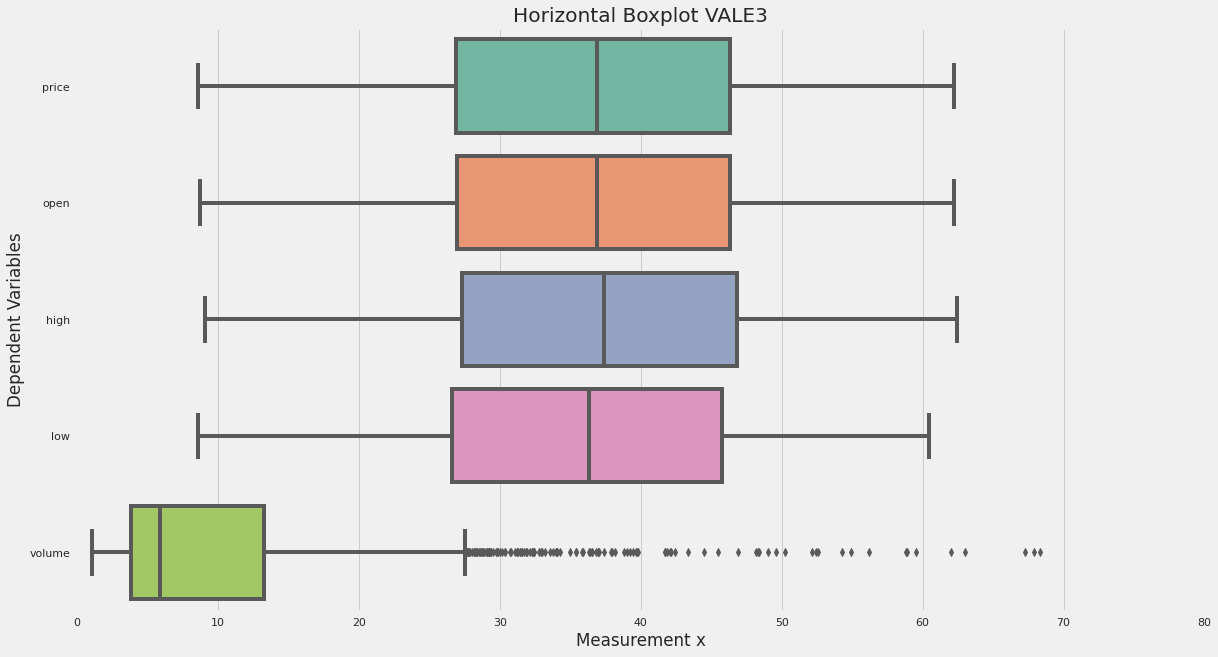

In [59]:
plot_box_plot(df_vale3_with_date, 
              'VALE3', 
              (0, 80))

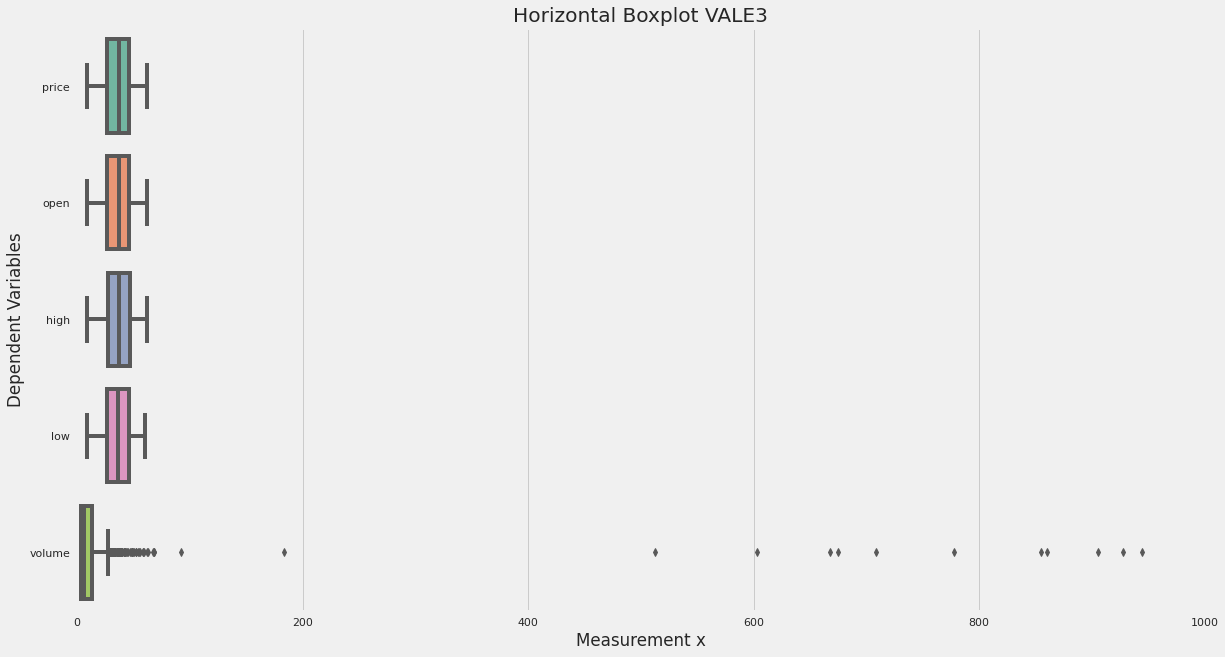

In [60]:
plot_box_plot(df_vale3_with_date, 
              'VALE3', 
              (0, 1000))

#### Histogram

<AxesSubplot:ylabel='Frequency'>

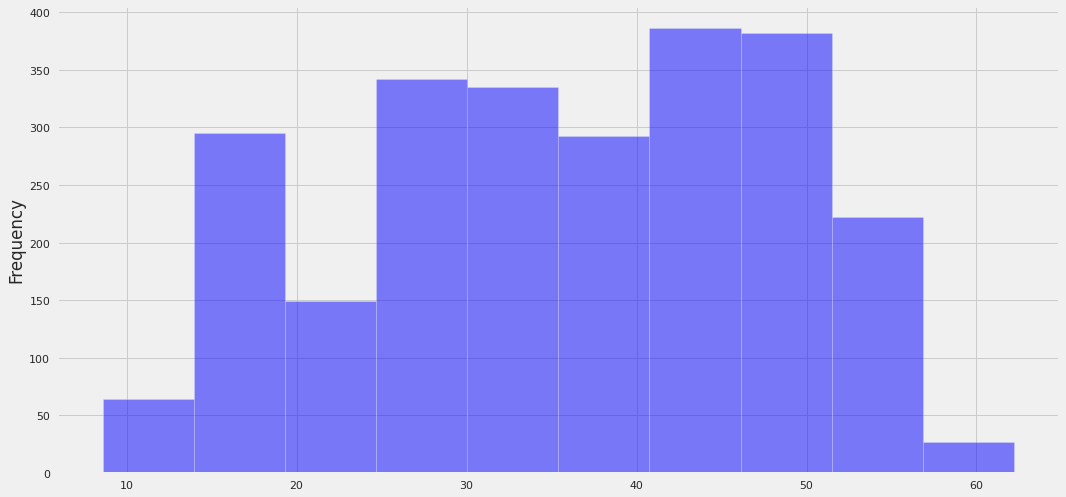

In [61]:
df_vale3_date_index['price'].plot.hist(alpha=0.5, color='blue')

## Time Series Behavior Analysis
- distribuition
- seasonal
- trend
- cyclic

#### Distribuition

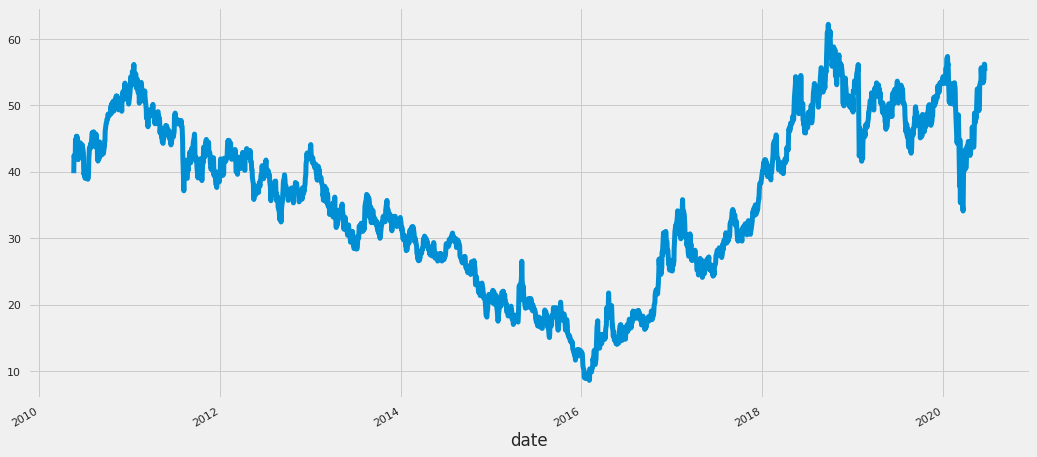

In [62]:
df_vale3_date_index['price'].plot(linewidth=5)
plt.grid(True)

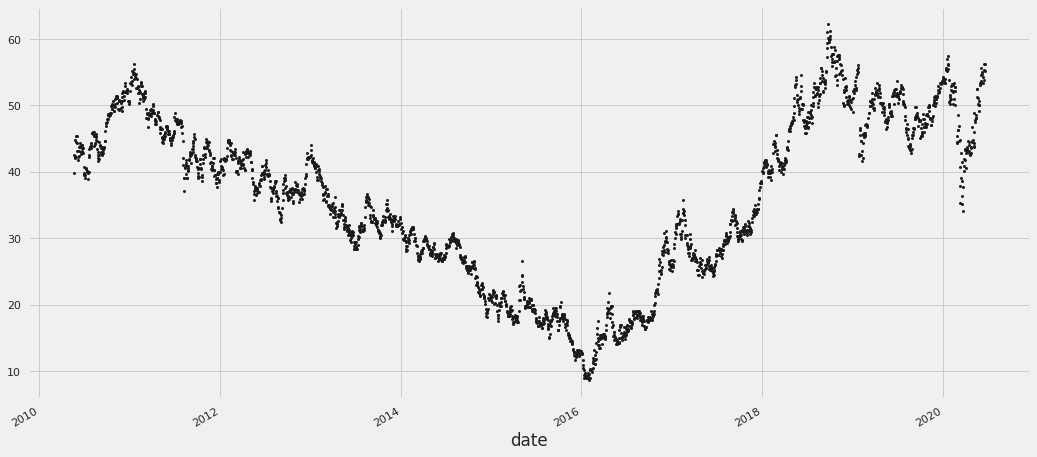

In [63]:
df_vale3_date_index['price'].plot(style='k.')
plt.grid(True)

#### By Year

Text(0.5, 1.0, 'VALE3 2020')

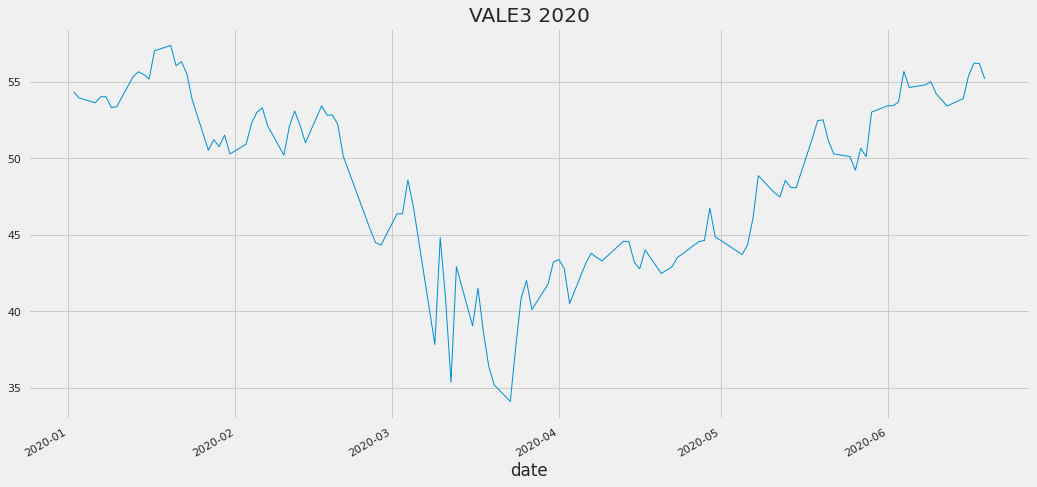

In [64]:
index_2020 = int(df_vale3_date_index.index.get_loc('2019-12-30', method='nearest'))

df_vale3_date_index['price'][:int(index_2020)].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2020')

Text(0.5, 1.0, 'VALE3 2019')

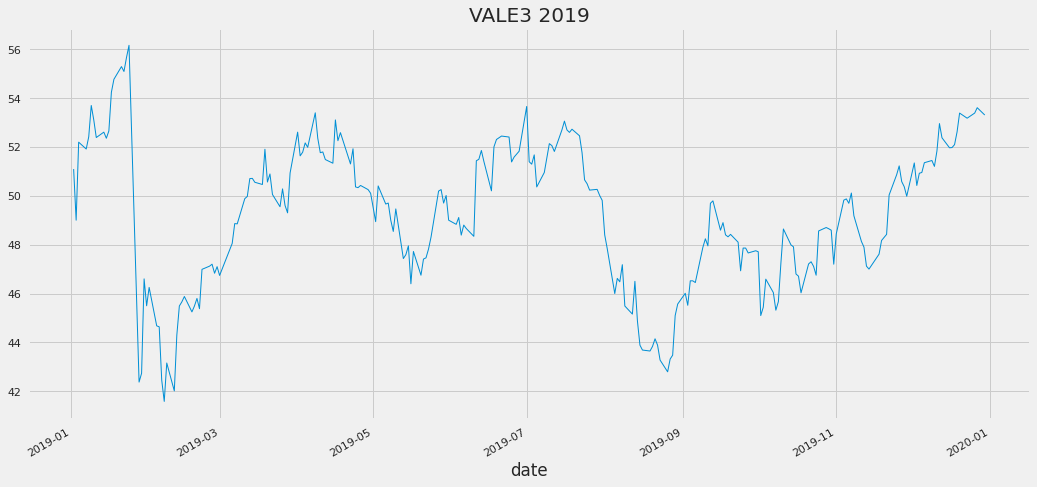

In [65]:
index_2019 = int(df_vale3_date_index.index.get_loc('2018-12-28', method='nearest'))

df_vale3_date_index['price'][index_2020:index_2019].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2019')

Text(0.5, 1.0, 'VALE3 2018')

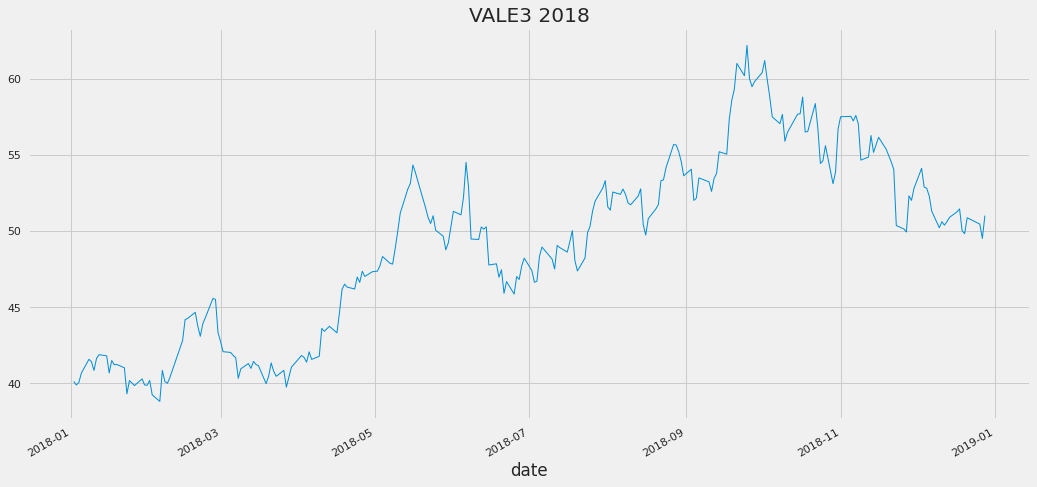

In [66]:
index_2018 = int(df_vale3_date_index.index.get_loc('2017-12-28', method='nearest'))

df_vale3_date_index['price'][index_2019:index_2018].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2018')

Text(0.5, 1.0, 'VALE3 2017')

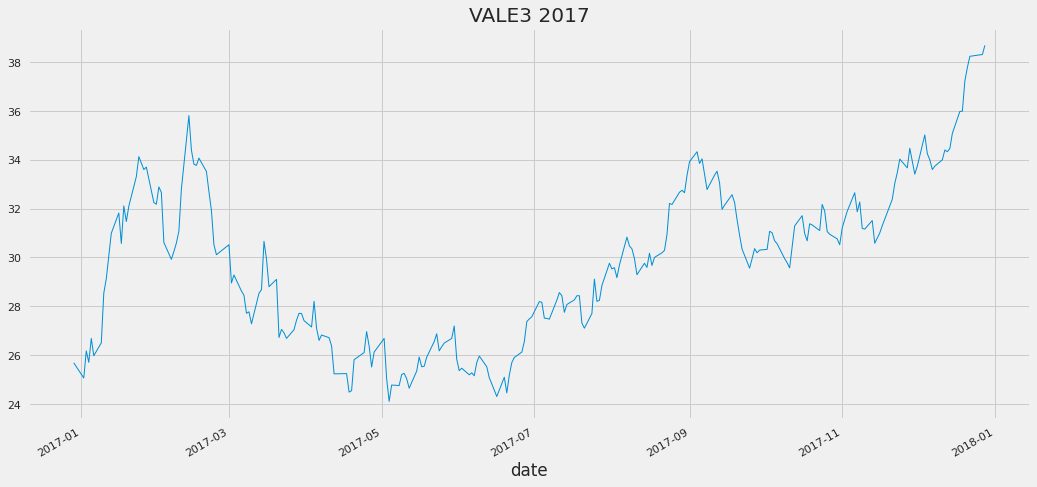

In [67]:
index_2017 = int(df_vale3_date_index.index.get_loc('2016-12-28', method='nearest'))

df_vale3_date_index['price'][index_2018:index_2017].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2017')

Text(0.5, 1.0, 'VALE3 2016')

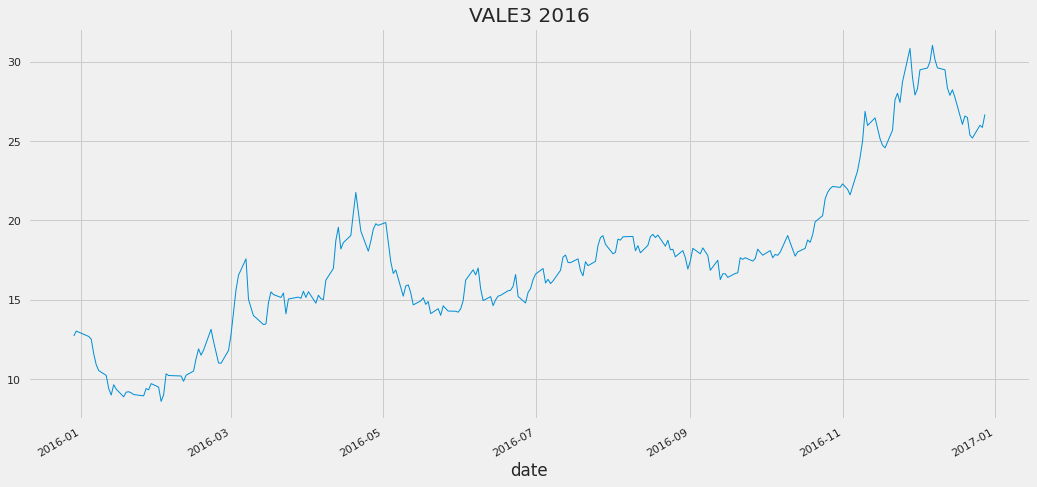

In [68]:
index_2016 = int(df_vale3_date_index.index.get_loc('2015-12-28', method='nearest'))

df_vale3_date_index['price'][index_2017:index_2016].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2016')

Text(0.5, 1.0, 'VALE3 2015')

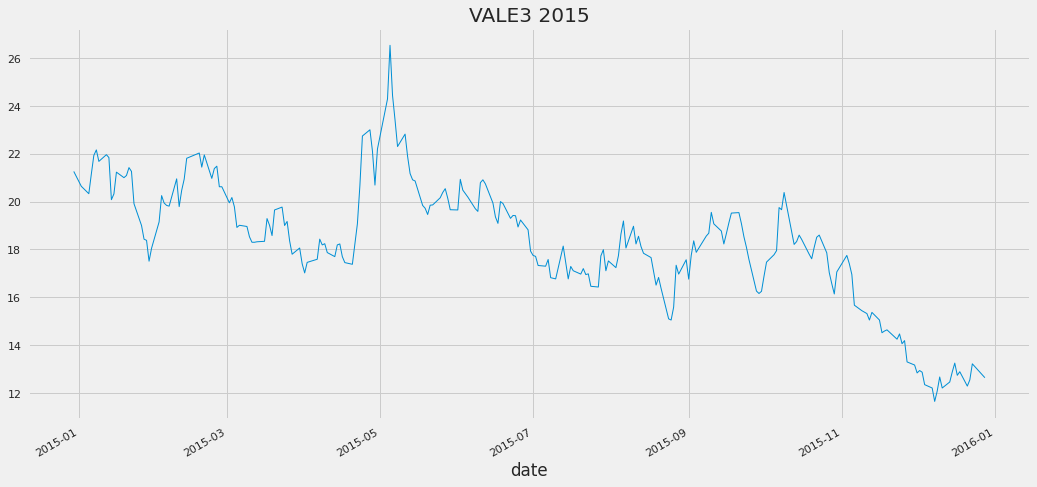

In [69]:
index_2015 = int(df_vale3_date_index.index.get_loc('2014-12-29', method='nearest'))

df_vale3_date_index['price'][index_2016:index_2015].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2015')

Text(0.5, 1.0, 'VALE3 2014')

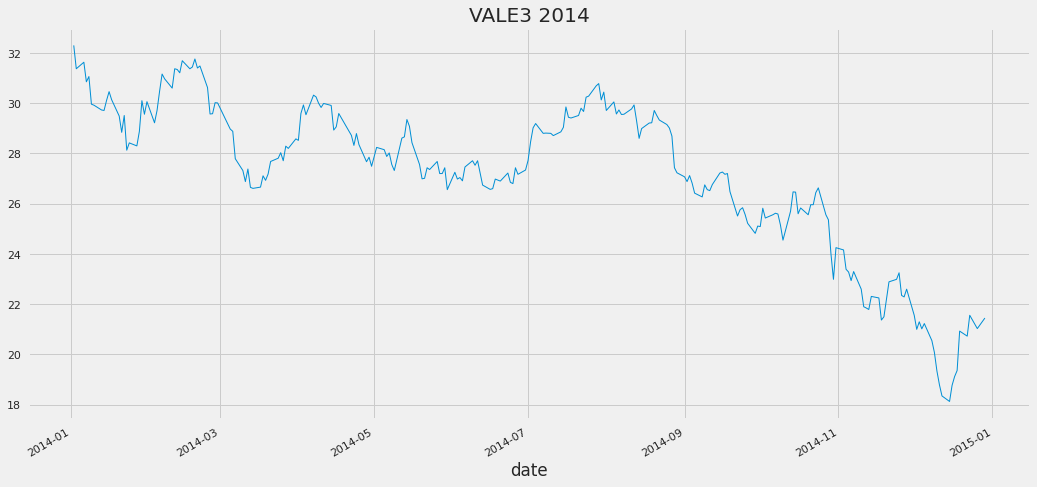

In [70]:
index_2014 = int(df_vale3_date_index.index.get_loc('2013-12-30', method='nearest'))

df_vale3_date_index['price'][index_2015:index_2014].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2014')

Text(0.5, 1.0, 'VALE3 2013')

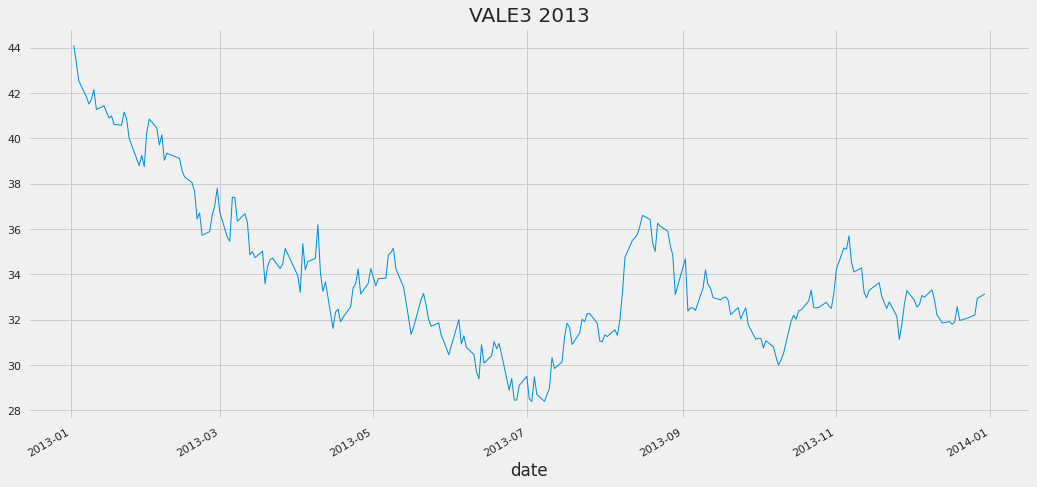

In [71]:
index_2013 = int(df_vale3_date_index.index.get_loc('2012-12-28', method='nearest'))

df_vale3_date_index['price'][index_2014:index_2013].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2013')

Text(0.5, 1.0, 'VALE3 2012')

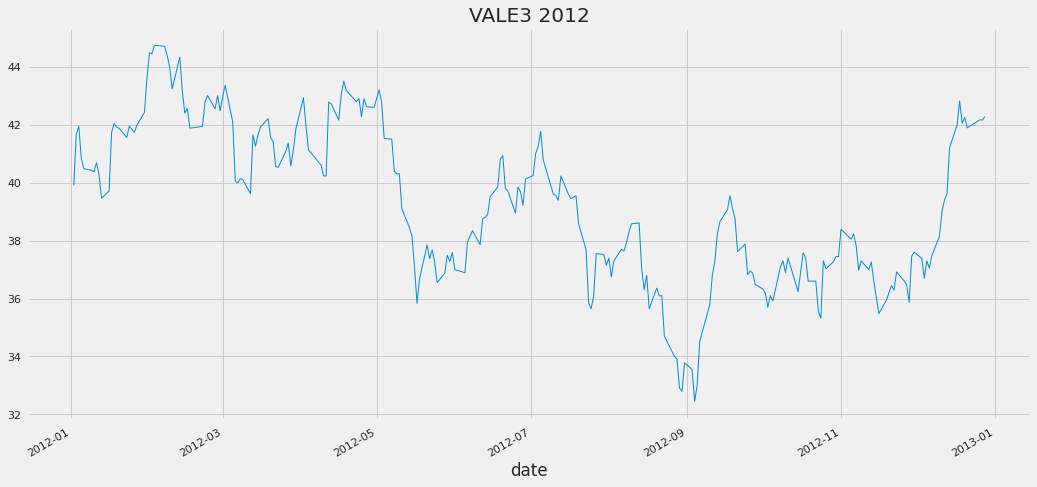

In [72]:
index_2012 = int(df_vale3_date_index.index.get_loc('2011-12-29', method='nearest'))

df_vale3_date_index['price'][index_2013:index_2012].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2012')

Text(0.5, 1.0, 'VALE3 2011')

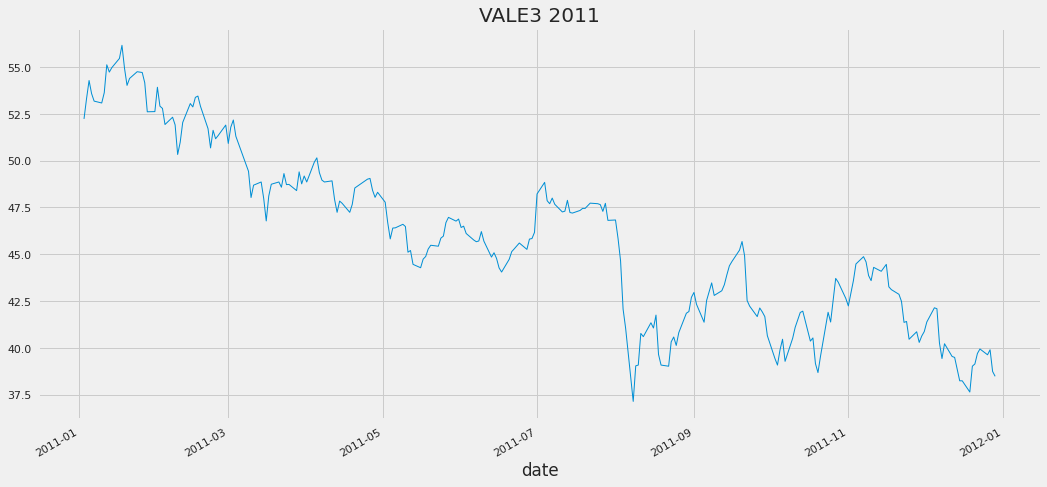

In [73]:
index_2011 = int(df_vale3_date_index.index.get_loc('2010-12-30', method='nearest'))

df_vale3_date_index['price'][index_2012:index_2011].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2011')

Text(0.5, 1.0, 'VALE3 2010')

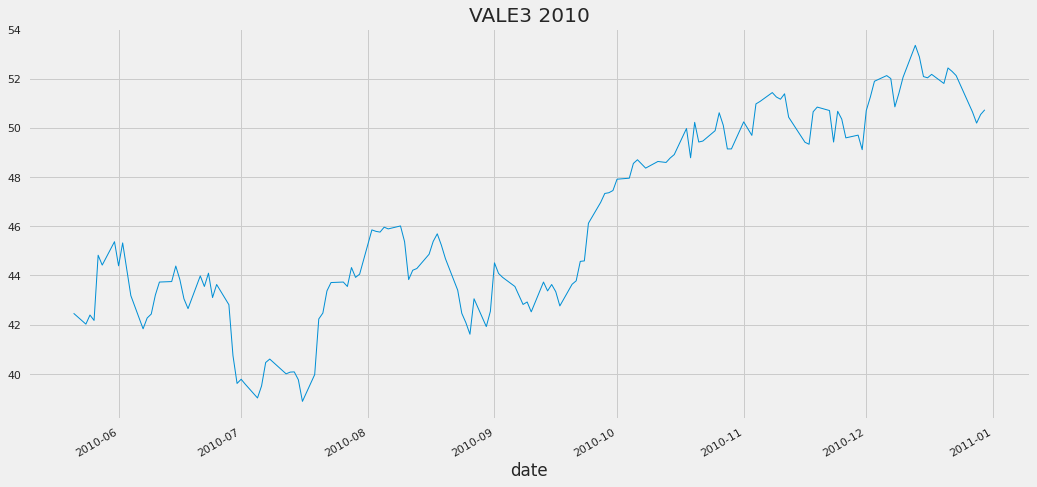

In [74]:
index_2010 = int(df_vale3_date_index.index.get_loc('2010-05-20', method='nearest'))

df_vale3_date_index['price'][index_2011:index_2010].plot(linewidth=1)
plt.grid(True)
plt.title(f'VALE3 2010')

#### **NOTE**
- Em torno dos 500 primeiros dias a ST aparenta estacionariedade
- Houve uma grande tendência de baixa, començando após alcançar o topo e durou aproximadamente 500 dias.
- Depois da tendência de baixa alvançar o fundo houve reversão de começando um ciclo de alta.
- O ciclo de alta já dura mais que 1000 dias

## **Stationarity Test**
É preciso garantir que os dados são estacionários. Significa que a série temporal possui um comportamento ao longo do tempo e que possui uma alta probabilidade de seguir este mesmo comportamento no futuro.

Visualmente a série não é estacionária. Para garantir o comportamento dessa série vou plotar as estatíticas de rolagem( ma, var) e fazer o teste de Dickey-Fuller.


Então neste teste avalio duas hipóteses:
- Hipótese nula (H0) : não é estacionária. Tem alguma estrutura dependente do tempo.
- Hipótese alternativa (H1) : é estacionária. Não tem estrutura dependente do tempo.

In [75]:
def rolling_stats(ts: 'dataframe', window: int) -> list:
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    
    return [rolling_mean, rolling_std]


def plot_rolling(ts: 'dataframe', *list_roll: list):
    mean = list_roll[0]
    std = list_roll[1]
    
    orig = plt.plot(ts, color='blue',label='Original', linewidth=1)
    mean = plt.plot(mean, color='red', label='Mean')
    std = plt.plot(std, color='black', label = 'Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()


def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, regression='nc', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

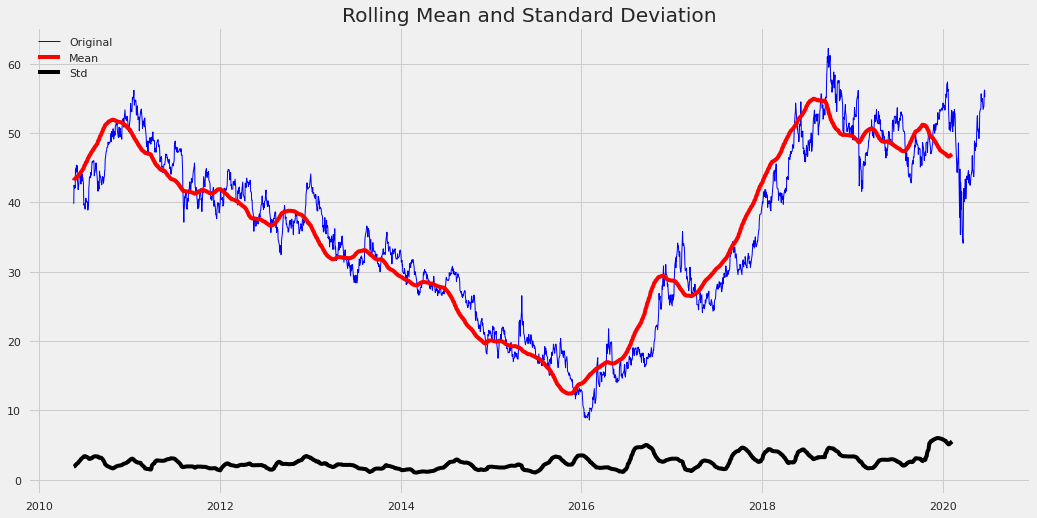

Results of Dickey-Fuller Test:
Test Statistic                -0.83313
p-value                        0.35664
#Lags Used                        15.0
Number of Observations Used     2479.0
Critical Value (1%)            -2.5666
Critical Value (5%)            -1.9411
Critical Value (10%)           -1.6167
dtype: float64


In [76]:
list_roll = rolling_stats(df_vale3['price'], window=90)
plot_rolling(df_vale3['price'], *list_roll)

test_stationarity(df_vale3['price'])

#### **NOTES**
- Usado `autolag='AIC'` para a própia função determinar o lag, escolhendo o menor valor observado.
- Test Statistic > Critical Value (1%), então a H0 é aceita, ou seja, não se tem estacionariedade na ST explorada

## **Decomposition Time Series**
- O objetivo é decompor a ST
- A ST aparenta ter duas tendências sendo os dois casos uma tendência linear do que exponencial, então a decomposição será `additive`

In [77]:
decomposition = seasonal_decompose(df_vale3['price'],
                                   freq=90,
                                   model='additive') 
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

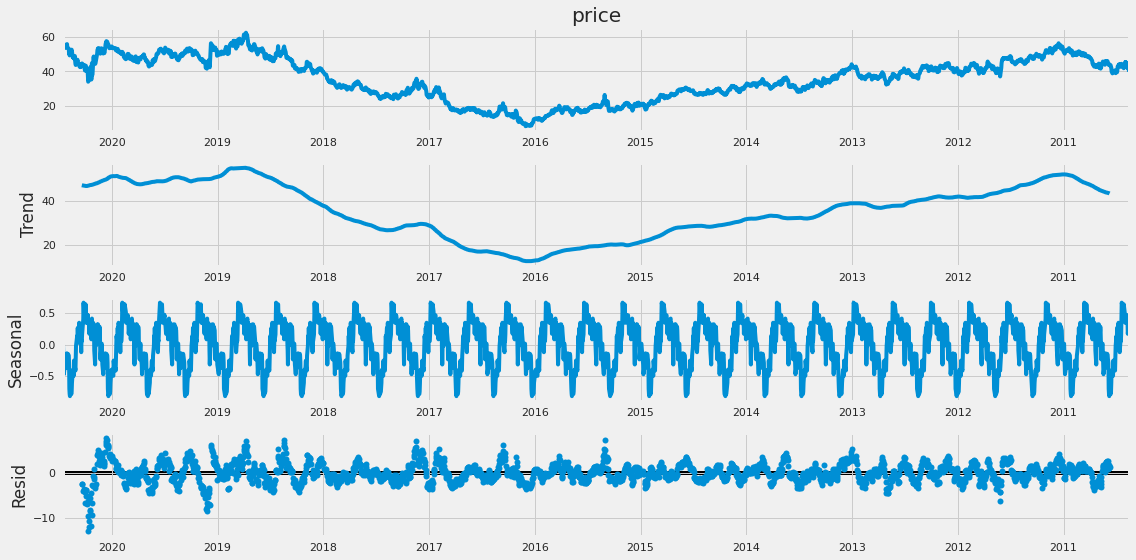

In [78]:
fig = decomposition.plot() 
plt.show()

NOTES

- A decomposição da ST demostra:
    - 2 grandes tendêcnias no decorrer de 10 anos
    - sazonalidade de 90 dias, onde demonstra melhor a tendência
    - muitos resíduos. O que se pode notar tambem é que nos últimos 5 anos os resíduos aumentaram

---

## Storage

In [79]:
def save_data_clenning(df: 'dataframe' = None,
                       path: str = 'data/cleansing') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "Data storage!"

In [80]:
df_vale3.head()

,date,price,open,high,low,volume,year,month,day
date,,,,,,,,,
2020-06-19,2020-06-19,55.17,56.33,56.6,54.71,37.86,2020,6,19
2020-06-18,2020-06-18,56.17,56.3,56.54,55.61,25.69,2020,6,18
2020-06-17,2020-06-17,56.2,55.49,56.44,55.15,27.57,2020,6,17
2020-06-16,2020-06-16,55.39,55.49,55.5,54.22,29.17,2020,6,16
2020-06-15,2020-06-15,53.88,52.5,54.43,52.13,27.32,2020,6,15


In [81]:
save_data_clenning(df = df_vale3,
                   path = 'data/cleansing/df_vale3_cleansing.csv')

'Data storage!'

---